In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
ab = '../../lr_bulk/talon/human_talon_abundance.tsv'
filt_ab = '../../lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
read_annot = '../../lr_bulk/talon/human_talon_read_annot.tsv'
t_metadata = '../../refs/cerberus/v40_transcript_metadata.tsv'
lib_metadata = '../../lr_bulk/lr_human_library_data_summary.tsv'
ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
swan_file = '../../lr_bulk/cerberus/swan/swan_meta.p'

mouse_lib_metadata = '../../mouse/lr_bulk/lr_mouse_library_data_summary.tsv'
mouse_swan_file = '../../mouse/lr_bulk/swan/swan.p'

sr_ab = '../../sr_bulk/TPM_matrix.tsv'


## Box plots for number of libraries, samples, and tissues / cell types

In [40]:
h_meta = pd.read_csv(lib_metadata, sep='\t')
m_meta = pd.read_csv(mouse_lib_metadata, sep='\t')

In [41]:
h_meta['species'] = 'Human'
m_meta['species'] = 'Mouse'
keep_cols = ['dataset', 'sample', 'general_tissue_cell_type', 'tissue_or_cell_line', 'species']
df = pd.concat([h_meta, m_meta], axis=0)[keep_cols]

In [42]:
# gb species and tissue_or_cell_line and count libraries
temp = df.groupby(['tissue_or_cell_line', 'species']).count().reset_index()
temp = temp[['tissue_or_cell_line', 'species', 'dataset']]
temp.rename({'dataset': 'n_libraries'}, axis=1, inplace=True)

# gb species and tissue_or_cell_line and count samples
temp2 = df.groupby(['tissue_or_cell_line', 'species']).nunique().reset_index()
temp2 = temp2[['tissue_or_cell_line', 'species', 'sample']]
temp2.rename({'sample': 'n_samples'}, axis=1, inplace=True)
temp = temp.merge(temp2, on=['species', 'tissue_or_cell_line'])

# gb species and tissue_or_cell_line and count general tissue / cell line
temp3 = df.groupby(['tissue_or_cell_line', 'species']).nunique().reset_index()
temp3 = temp3[['tissue_or_cell_line', 'species', 'general_tissue_cell_type']]
temp3.rename({'general_tissue_cell_type': 'n_general'}, axis=1, inplace=True)
temp = temp.merge(temp3, on=['species', 'tissue_or_cell_line'])



In [43]:
temp.head()

,tissue_or_cell_line,species,n_libraries,n_samples,n_general
0,cell_line,Human,87,39,30
1,cell_line,Mouse,9,3,2
2,tissue,Human,51,11,11
3,tissue,Mouse,117,28,6


In [44]:
def make_summary_box_plot(temp, y, ylabel, ofile):
    sns.set_context('paper', font_scale=2)
    plt.figure(figsize=(3,4))
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42

    c_dict, order = get_tissue_cell_line_colors()    
    ax = sns.barplot(data=temp, x='species', y=y,
                hue='tissue_or_cell_line',
                palette=c_dict, saturation=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    xlabel = ''
    ylabel = ylabel

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    _ = ax.set(xlabel=xlabel, ylabel=ylabel)

    def add_perc_2(ax):
        ylim = ax.get_ylim()[1]
        n_cats = len(ax.patches)
        for p in ax.patches:
            label = '{:.0f}'.format(p.get_height())
            x = p.get_x() + p.get_width() / 2
            y = p.get_y() + p.get_height() + ylim*0.01
            ax.annotate(label, (x, y), size=16, horizontalalignment='center')


    add_perc_2(ax)
    plt.savefig(ofile, dpi=500, layout='tight', bbox_inches="tight")

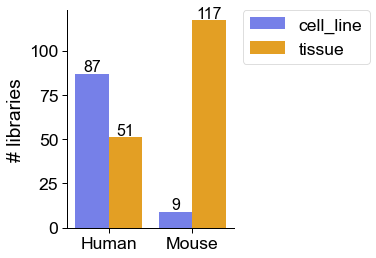

In [45]:
make_summary_box_plot(temp, 'n_libraries', '# libraries', 'figures/library_box_plot.pdf')

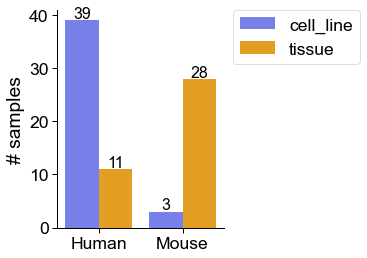

In [48]:
make_summary_box_plot(temp, 'n_samples', '# samples', 'figures/sample_box_plot.pdf')

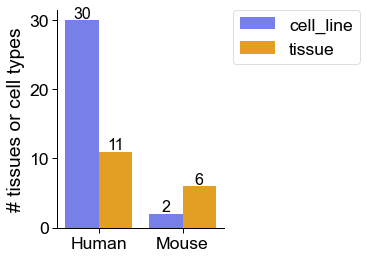

In [49]:
make_summary_box_plot(temp, 'n_general', '# tissues or cell types', 'figures/general_box_plot.pdf')

## Number of libraries vs. number of tissues / cell lines

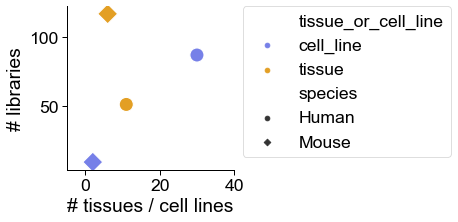

In [53]:
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(3,3))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

style_dict = {'Human': 'o', 'Mouse': 'D'}
c_dict, order = get_tissue_cell_line_colors()
ax = sns.scatterplot(data=temp, x='n_general', y='n_libraries',
            hue='tissue_or_cell_line', style='species', markers=style_dict,
            palette=c_dict, alpha=1, s=200)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

xlabel = '# tissues / cell lines'
ylabel = '# libraries'
xlim = (-5, 40)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
_ = ax.set(xlabel=xlabel, ylabel=ylabel, xlim=xlim)

fname = 'figures/data_summary_libraries_v_tissue_cell_line.pdf'
plt.savefig(fname, dpi=500, layout='tight', bbox_inches="tight")

## Human sample color legend

Read in graph from ../../lr_bulk/cerberus/swan/swan_meta.p


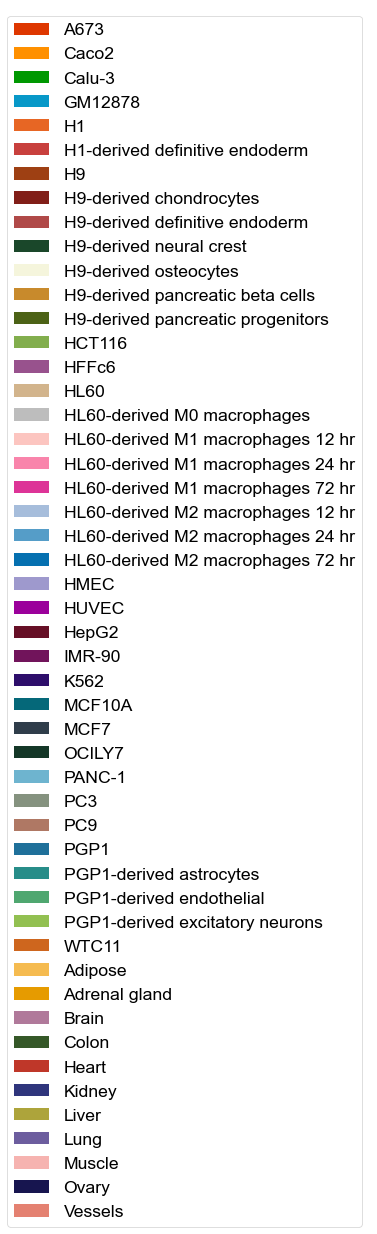

In [3]:
plot_human_sample_legend(swan_file,
                   'human_sample_color_legend.pdf')

## Mouse sample color legend

Read in graph from ../../mouse/lr_bulk/swan/swan.p


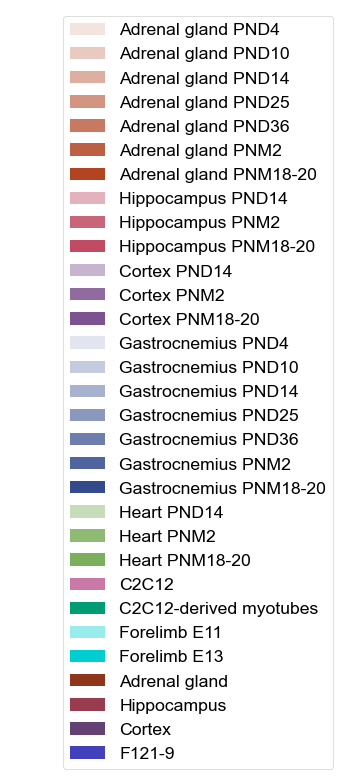

In [4]:
plot_mouse_sample_legend(mouse_swan_file,
                   'mouse_sample_color_legend.pdf')

## Short-read gene detection by biotype from all samples

Calculating short-read gene TPM values
Subsetting for polya genes
Applying gene type subset
Number of genes reported: 49093
Detected 49093 / 52274 (93.9%) annotated polyA genes
protein_coding
92.13027816690014

lncRNA
53.10457516339869

pseudogene
44.641628834777826



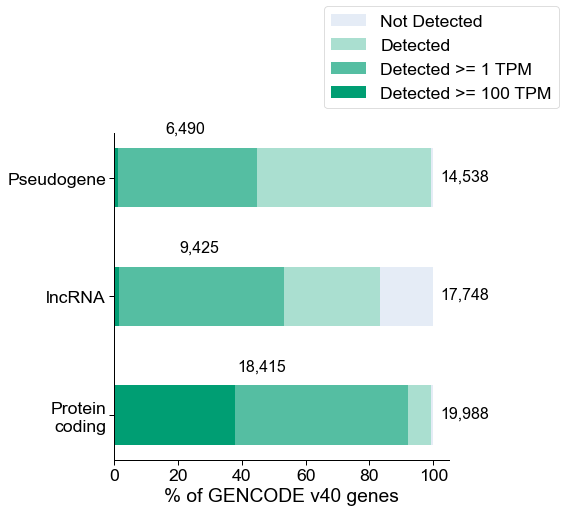

In [7]:
df = pd.read_csv(sr_ab, sep='\t')
plot_gene_det_by_biotype_tpm(df,
                             how='sr',
                             ver=ver,
                             opref='figures/sr_')

## Short read gene detection by biosample for all samples

Calculating short-read gene TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 58780
# genes >= 1 tpm: 38053
Applying gene type subset
Number of genes reported: 34330
Found 78 total samples


<Figure size 432x288 with 0 Axes>

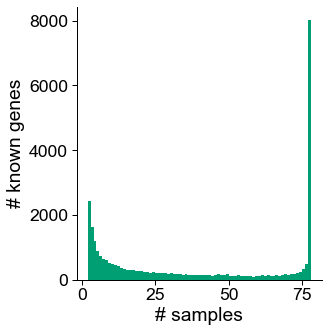

In [8]:
df = pd.read_csv(sr_ab, sep='\t')
df = plot_biosamp_det(df,
                 how='sr',
                 min_tpm=min_tpm,
                 gene_subset=gene_subset,
                 groupby='sample',
                 opref='figures/sr')

In [5]:
# number of additional samples that were sequences with short read
# that weren't with long read
78-41

37

## UMAP for short-read on matching samples

In [3]:
plot_sr_brain_tissue_cell_line_umap(sr_ab,
                                    lib_metadata,
                                    min_tpm,
                                    gene_subset,
                                    'lr_match'
                                    'figures/sr_gene_lr_match_brain_tissue_cell_line_umap.pdf')

TypeError: plot_sr_brain_tissue_cell_line_umap() missing 1 required positional argument: 'sample'

In [91]:
df = pd.read_csv(sr_ab, sep='\t')
df, gids = get_tpm_table(df,
                 how='sr',
                 min_tpm=min_tpm,
                 sample='lr_match',
                 gene_subset=gene_subset)
df = df.transpose()

X = df.values

# obs table w/ sample info
obs = df.index.to_frame()
obs.rename({0: 'dataset'}, axis=1, inplace=True)
obs['biosample'] = obs.dataset.str.rsplit('_', n=2, expand=True)[0]
tissue_df = get_tissue_metadata()
tissue_df = tissue_df[['tissue', 'biosample']]
obs = obs.merge(tissue_df, how='left', on='biosample')
obs.loc[obs.tissue.isnull(), 'tissue'] = obs.loc[obs.tissue.isnull(), 'biosample']
obs.drop('biosample', axis=1, inplace=True)
obs.rename({'tissue': 'sample'}, axis=1, inplace=True)
obs['sample'].unique()
obs['dataset'] = obs['dataset'].astype('string')

# var
var = pd.DataFrame(data=df.columns.tolist(), columns=['gid'])
var['gid'] = var['gid'].astype('string')

adata = anndata.AnnData(obs=obs, var=var, X=X)

# limit only to samples that are in the long-read
c_dict, order = get_biosample_colors()
adata = adata[adata.obs['sample'].isin(order)]


Calculating short-read gene TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 58780
# genes >= 1 tpm: 38053
Applying gene type subset
Number of genes reported: 34330


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [92]:
meta = pd.read_csv(lib_metadata, sep='\t')
meta = meta[['sample', 'tissue_or_cell_line']].drop_duplicates()

# add colors
# map values in order specific to
obs_col = 'sample'
cmap, order = get_biosample_colors()
adata.obs[obs_col] = adata.obs[obs_col].astype('category')
obs_order = list(adata.obs_names)
sample_order = adata.obs[obs_col].cat.categories.tolist()
sample_colors = [cmap[s] for s in sample_order]
adata.uns['{}_colors'.format(obs_col)] = sample_colors

# also store rgb values in dict for use with gen_report
for key, item in cmap.items():
    item = item[1:]
    r,g,b = tuple(int(item[i:i+2], 16) for i in (0, 2, 4))
    cmap[key] = (r,g,b)
adata.uns['{}_dict'.format(obs_col)] = cmap

# add tissue / cell line info
adata.obs = adata.obs.merge(meta, how='left', on='sample')
obs_col = 'brain_tissue_cell_line'
adata.obs[obs_col] = adata.obs.tissue_or_cell_line
adata.obs.loc[adata.obs['sample']=='brain', obs_col] = 'brain'

# add colors
# map values in order specific to
cmap, order = get_tissue_cell_line_colors()
cmap2, _ = get_biosample_colors()
brain_color = cmap2['brain'] 
order += ['brain']
cmap['brain'] = brain_color
adata.obs[obs_col] = adata.obs[obs_col].astype('category')
obs_order = list(adata.obs_names)
sample_order = adata.obs[obs_col].cat.categories.tolist()
sample_colors = [cmap[s] for s in sample_order]
adata.uns['{}_colors'.format(obs_col)] = sample_colors

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [93]:
adata.obs.set_index('dataset', inplace=True)
adata.var.set_index('gid', inplace=True)

In [94]:
print(len(adata.var.index))

# # normalize data matrix to 10,000 count
# sc.pp.normalize_total(adata, target_sum=1e4)

# log 
sc.pp.log1p(adata)
adata.raw = adata

# find highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes = 20000, flavor = 'seurat',
    min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pp.highly_variable_genes(adata, n_top_genes = 5000, flavor = 'seurat',
#     min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

# sc.tl.pca(adata, use_highly_variable=False)
sc.tl.pca(adata, use_highly_variable=True)

sc.pp.neighbors(adata, metric='cosine')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

34330


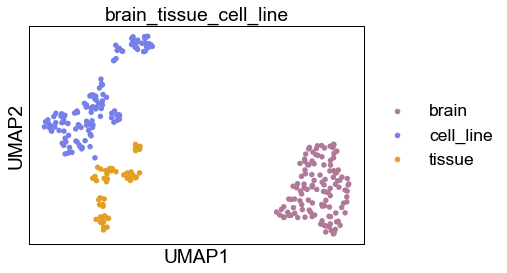

In [97]:
sc.pl.umap(adata, color='brain_tissue_cell_line', frameon=True, size=120, show=False)

f = plt.gcf()
f.savefig('figures/sr_umap_gene_brain_tissue_cell_line.pdf', dpi=500, bbox_inches='tight')